In [1]:
from helpers import math_helper
from sensors.activpal import *
from utils import read_functions
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import statistics
import os

    #NEW RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# END


# Feature Extraction

In [2]:
activpal = Activpal()

#features_columns = ['standard_deviation_x', 'mean_x', 'standard_deviation_y', 'mean_y','standard_deviation_z', 'mean_z', 'activiteit']
features_columns = ['standard_deviation_x', 'mean_x', 'standard_deviation_y', 'mean_y','standard_deviation_z', 'mean_z', 'peak_distance_x', 'peak_distance_y','peak_distance_z', 'activiteit']

activities = ['lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']
segment_size = 12.8

In [3]:
def calculate_peak_distance(activpal_segment, key):
    accelerations = activpal_segment[key]

    # todo: Think about what kind peaks we are looking for and what we want to with it
    peak_index, _ = signal.find_peaks(accelerations)

    if len(peak_index) < 2:
        return 0

    peak_values = [accelerations[i] for i in peak_index]

    peak_values.sort(reverse=True)

    # There is a change there are is peak that shows up at multiple index
    # For this reason i am taking the index with highest value.
    highest_peak_index = activpal_segment[activpal_segment[key] == peak_values[0]].index.max()
    second_highest_peak_index = activpal_segment[activpal_segment[key] == peak_values[1]].index.max()

    diff_time = max(highest_peak_index, second_highest_peak_index) - min(highest_peak_index, second_highest_peak_index)

    # It's better to use microseconds diveded by 1000 to get milliseconds. This way you won't lose information
    # return diff_time.seconds * 1000
    return diff_time.microseconds / 1000


In [4]:
def extract_features_from_correspondent(correspondent):
    features_df = pd.DataFrame(columns=features_columns, index=pd.to_datetime([]))

    # Getting dataset for a correspodent
    activities_df = read_functions.read_activities(correspondent)

    for activity_name in activities:
        activity = activities_df.loc[activity_name]
        if not activity.empty:
            start_time = activity.start
            stop_time = activity.stop
            activpal_df = activpal.read_data(correspondent, start_time, stop_time)

            # denormalizing dataset
            activpal_df['x'] = math_helper.convert_value_to_g(activpal_df['pal_accX'])
            activpal_df['y'] = math_helper.convert_value_to_g(activpal_df['pal_accY'])
            activpal_df['z'] = math_helper.convert_value_to_g(activpal_df['pal_accZ'])

            date_range = pd.date_range(start_time, stop_time, freq=str(segment_size) + 'S')
            for time in date_range:
                segment_time = time + pd.DateOffset(seconds=segment_size)
                activpal_segment = activpal_df[(activpal_df.index >= time) & (activpal_df.index <= segment_time)]

                # features
                peak_distance_x = calculate_peak_distance(activpal_segment, 'x')
                peak_distance_y = calculate_peak_distance(activpal_segment, 'y')
                peak_distance_z = calculate_peak_distance(activpal_segment, 'z')

                # stdev_x = lambda statistics.stdev(activpal_segment['x']) if len(activpal_segment['x']) >= 2 else 0
                stdev_x =  statistics.stdev(activpal_segment['x']) if len(activpal_segment['x']) >= 2 else 0
                mean_x = activpal_segment['x'].mean()

                stdev_y =  statistics.stdev(activpal_segment['y']) if len(activpal_segment['y']) >= 2 else 0
                mean_y = activpal_segment['y'].mean()

                stdev_z =  statistics.stdev(activpal_segment['z']) if len(activpal_segment['z']) >= 2 else 0
                mean_z = activpal_segment['z'].mean()  


              #  features_df.loc[segment_time] = [stdev_x, mean_x, stdev_y, mean_y, stdev_z, mean_z, activity_name]
                features_df.loc[segment_time] = [stdev_x, mean_x, stdev_y, mean_y, stdev_z, mean_z, peak_distance_x, peak_distance_y, peak_distance_z,  activity_name]

    return features_df

In [5]:
def extract_features_from_all_correspondents():
    all_features_df = pd.DataFrame(index=pd.to_datetime([]))

    for directory in os.walk('../../data'):
        if directory[0] == '../../data':
            for respDirect in directory[1]:
                if respDirect not in ['output', 'throughput', 'Test data','.ipynb_checkpoints', 'BMR035', 'BMR100', 'BMR051', 'BMR027']:
                    print("Extracting " + respDirect)
                    features_df = extract_features_from_correspondent(respDirect)
                    all_features_df = pd.concat([all_features_df, features_df])

    print("Done extracting features")

    return all_features_df

In [6]:
features_dataset = extract_features_from_all_correspondents()

Extracting BMR099
Extracting BMR025
Extracting BMR060
Extracting BMR012
Extracting BMR030
Extracting BMR044
Extracting BMR043
Extracting BMR004
Extracting BMR011
Extracting BMR098
Extracting BMR034
Extracting BMR014
Extracting BMR036
Extracting BMR052
Extracting BMR002
Extracting BMR031
Extracting BMR097
Extracting BMR008
Extracting BMR015
Extracting BMR033
Extracting BMR064
Extracting BMR055
Extracting BMR041
Extracting BMR053
Extracting BMR042
Extracting BMR018
Extracting BMR058
Extracting BMR040
Extracting BMR032
Done extracting features


# Balancing dataset

In [7]:
def balance_dataset_by_activity(dataset):
    highest_frequency  = dataset.groupby('activiteit').count()['standard_deviation_x'].max()
    unbalanced_dataset = dataset.copy()
    
    for activity_name in unbalanced_dataset.activiteit.unique():
        activity_data = unbalanced_dataset[unbalanced_dataset['activiteit'] == activity_name]
        
        multiplier =  int(highest_frequency / len(activity_data)) - 1
        unbalanced_dataset = unbalanced_dataset.append([activity_data] * multiplier, ignore_index=True)    
        
        activity_amount = len(unbalanced_dataset[ unbalanced_dataset['activiteit'] == activity_name])
        missing_amount = highest_frequency - activity_amount
        unbalanced_dataset = unbalanced_dataset.append(activity_data[:missing_amount], ignore_index=True)    

    return unbalanced_dataset

features_dataset = balance_dataset_by_activity(features_dataset)

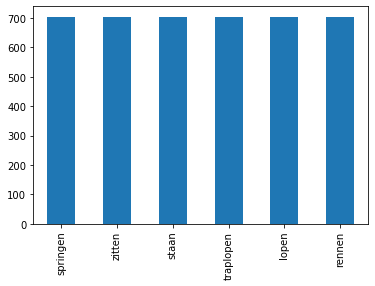

In [8]:
features_dataset['activiteit'].value_counts().plot.bar()

# model preperation

In [9]:
activities = ['lopen', 'rennen', 'springen', 'staan', 'traplopen', 'zitten']

features_dataset[['activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen',
                  'activity_sitten']] = 0

In [10]:
features_dataset.loc[(features_dataset['activiteit'] == 'lopen'), 'activity_walking'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'rennen'), 'activity_running'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'springen'), 'activity_jumping'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'staan'), 'activity_standing'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'traplopen'), 'activity_traplopen'] = 1
features_dataset.loc[(features_dataset['activiteit'] == 'zitten'), 'activity_sitten'] = 1
features_dataset.drop('activiteit', axis=1, inplace=True)

In [11]:
for column in features_columns[:-1]:
    features_dataset[column].fillna(0, inplace=True)

In [12]:
features_dataset.head()

,standard_deviation_x,mean_x,standard_deviation_y,mean_y,standard_deviation_z,mean_z,peak_distance_x,peak_distance_y,peak_distance_z,activity_walking,activity_running,activity_jumping,activity_standing,activity_traplopen,activity_sitten
0,0.400827,-1.048051,0.313266,0.028658,0.493007,0.184609,399.993,0.003,0.0,1,0,0,0,0,0
1,0.478785,-1.029443,0.330056,0.038406,0.565512,0.154373,999.996,599.995,0.0,1,0,0,0,0,0
2,0.508147,-1.046631,0.352266,0.036316,0.536173,0.160027,349.993,100.001,0.0,1,0,0,0,0,0
3,0.528202,-1.011204,0.396568,0.022533,0.599671,0.150638,450.000,249.996,0.0,1,0,0,0,0,0
4,0.526253,-1.026743,0.383155,0.023408,0.561279,0.148107,199.997,450.003,0.0,1,0,0,0,0,0


## Preparing feature dataset for learning
### Splitting in x and y

In [13]:
x = features_dataset[features_columns[:-1]]
y = features_dataset[['activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen', 'activity_sitten']]
train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.2, random_state=23, stratify=y)

In [14]:
# ## WORK IN PROGRESS
# x, y = make_classification(n_samples=1600, n_features=9, n_informative=9, n_redundant=0, random_state=1)
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# model = DecisionTreeClassifier()
# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
 

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [15]:
train_x.head()

,standard_deviation_x,mean_x,standard_deviation_y,mean_y,standard_deviation_z,mean_z,peak_distance_x,peak_distance_y,peak_distance_z
3678,0.201742,-1.092971,0.202561,0.048073,0.208261,0.222676,50.000,300.007,249.999
4142,0.516105,-1.096234,0.309056,0.239153,0.394643,0.211702,600.004,899.992,150.001
3183,0.334857,-0.953740,0.205250,-0.113829,0.362671,0.061886,100.000,899.995,649.997
3382,0.236063,-0.990352,0.145241,0.035792,0.228462,0.034174,149.999,299.997,549.996
3566,0.272816,-1.019297,0.189206,-0.036539,0.385552,0.153066,199.999,450.006,100.000


# Decision Tree model

In [16]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(train_x, train_y)

DecisionTreeClassifier()

## results

Random seed: 23


|Features| |
|-----| ----|
| standard_deviation_x| mean_x|
| standard_deviation_y| mean_y|
| standard_deviation_z| mean_z|
| peak_distance_x| peak_distance_y|
| peak_distance_z| activiteit|

| Time range | Accuracy | Precision |  Recall |
| ------ | ------ | ------ | ------ |
| 0.4S | 80% | 86% | 80%
| 0.8S | 82% | 90% | 82%
| 1.0S | 83% | 90% | 83%
| 1.6S | 83% | 90% | 83%
| 2.0S | 83% | 90% | 83%
| 3.2S | 83% | 89.5% | 83%
| 4.0S | 83% | 90.5% | 82%
| 6.4S | 84% | 90% | 85% 
| 8.0S | 85% | 91% | 85% 
| 12.8S | 87% | 92% | 87%

12.8S gives the best result

In [17]:
prediction_y = dtc.predict(valid_x)

#### Accuracy

In [18]:
accuracy_score(valid_y, prediction_y)

0.9633136094674556

#### Precision

In [19]:
precision_score(valid_y, prediction_y, average='micro')

0.9633136094674556

#### Recall

In [20]:
recall_score(valid_y, prediction_y , average='micro')

0.9633136094674556

# Random tree forest

In [21]:
#from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#train_x = sc.fit_transform(train_x)
#valid_x = sc.transform(valid_x)

In [22]:
rfc = RandomForestClassifier(n_estimators=20, random_state=0)
rfc.fit(train_x, train_y)

RandomForestClassifier(n_estimators=20, random_state=0)

## Result

In [23]:
prediction_y = rfc.predict(valid_x)

### classification_report

#### Accuracy

In [24]:
accuracy_score(valid_y, prediction_y, normalize=True)

0.9656804733727811

In [25]:
print(classification_report(valid_y, prediction_y, target_names=['activity_walking', 'activity_running', 'activity_jumping', 'activity_standing', 'activity_traplopen',
                  'activity_sitten'], zero_division=0))

                    precision    recall  f1-score   support

  activity_walking       0.98      0.90      0.94       140
  activity_running       0.99      0.94      0.96       141
  activity_jumping       0.97      1.00      0.98       141
 activity_standing       0.95      0.98      0.97       141
activity_traplopen       0.99      1.00      0.99       141
   activity_sitten       1.00      0.97      0.99       141

         micro avg       0.98      0.97      0.97       845
         macro avg       0.98      0.97      0.97       845
      weighted avg       0.98      0.97      0.97       845
       samples avg       0.97      0.97      0.97       845

